In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy as pt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/roualdes/data/refs/heads/master/penguins.csv')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


# 1. Simple Logistic Regression

In [3]:
df.isnull().sum()

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11
year,0


In [4]:
df["biscoe"] = df["island"] == "Biscoe"
df["biscoe"] = df["biscoe"].astype("int64")
df2 = df.dropna(subset = ["biscoe", "bill_depth_mm"])
df2.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,biscoe
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007,0


In [5]:
y, X = pt.dmatrices("biscoe ~ bill_depth_mm", df2)
y = np.reshape(y, -1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=608)

## a. Fit logistic regression

In [7]:
fit = LogisticRegression(fit_intercept=False, penalty=None).fit(X_train, y_train)
fit.coef_

array([[17.61710677, -1.0269193 ]])

## b. Predict probability for penguin having bill_depth of 17.1 mm

In [8]:
beta = fit.coef_[0]

bill_depth = 17.1
lm = beta[0] + beta[1] * bill_depth
p1 = 1 / (1 + np.exp(-lm))
print(f"Predicted probability for bill_depth_mm {bill_depth} = {p1:.4f}")

Predicted probability for bill_depth_mm 17.1 = 0.5142


The model predicts a 51.42% probability that a penguin with a bill depth of 17.1 mm is from the island Biscoe.

## c. Classify a penguin with a bill depth of 17.1 millimeters as from the island Biscoe or not

In [9]:
classification = "Biscoe" if p1 >= 0.5 else "Not Biscoe"
print(f"The penguin is classified as: {classification}")

The penguin is classified as: Biscoe


The logistic regression model predicts a probability (p1) of the penguin being from Biscoe based on its bill depth.

In this case, the model predicted p1 as greater than or equal to 0.5, meaning the penguin is more likely to be from Biscoe than not.

Therefore, the penguin is classified as Biscoe using the threshold of 0.5.


## d. If your fledgling penguin grew just 1 millimeter in bill depth, what is the expected change in probability for the penguin being from the island Biscoe?

In [10]:
beta = fit.coef_[0]

bill_depth = 18.1
lm = beta[0] + beta[1] * bill_depth
p2 = 1 / (1 + np.exp(-lm))
print("p2: ", p2)
prob_change = p2 - p1
print("prob_change: ", prob_change)
print(f"Change in probability for a 1 mm increase: {prob_change:.4f}")

p2:  0.27485409478827416
prob_change:  -0.23933879281297277
Change in probability for a 1 mm increase: -0.2393


The change in probability is -0.2393, meaning that as the bill depth increases by 1 mm (from 17.1 mm to 18.1 mm), the probability of the penguin being from the island Biscoe decreases by 23.93%.

## e. Calculate the confusion matrix

In [11]:
y_pred = fit.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred, normalize = 'all')

simple_Log_accuracy = accuracy_score(y_test, y_pred)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Model Accuracy: {simple_Log_accuracy:.4%}")

Confusion Matrix:
[[0.42028986 0.13043478]
 [0.13043478 0.31884058]]
Model Accuracy: 73.9130%


**True Negatives (TN): 0.4203 (42.03%)**

Correctly predicted as "Not Biscoe."

**False Positives (FP): 0.1304 (13.04%)**

Incorrectly predicted as "Biscoe" when it was actually "Not Biscoe."

**False Negatives (FN): 0.1304 (13.04%)**

Incorrectly predicted as "Not Biscoe" when it was actually "Biscoe."

**True Positives (TP): 0.3188 (31.88%)**

Correctly predicted as "Biscoe."

The overall accuracy of the model is 73.91%, meaning it correctly classified approximately 74% of the penguins in the test set.

# 2. Penalized Logistic Regression

## a. Fit Penalized regression

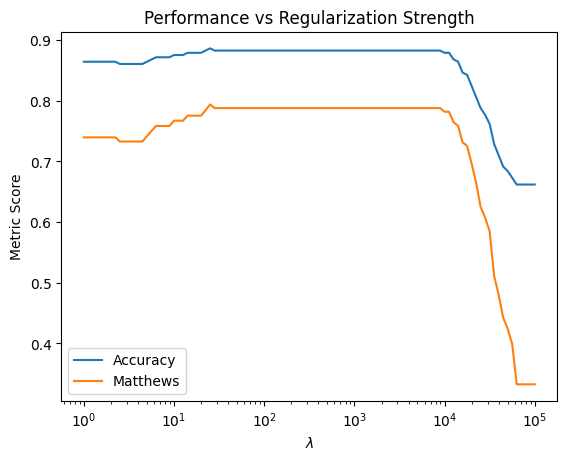

In [12]:
y, X = pt.dmatrices("biscoe ~ bill_depth_mm * bill_length_mm * body_mass_g + I(bill_depth_mm ** 2)", df2)
y = np.reshape(y, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=608)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lambdas = np.logspace(0, 5, 101)
approx_accuracy = np.zeros_like(lambdas)
approx_matthews = np.zeros_like(lambdas)

for li, l in enumerate(lambdas):
    cv_approx = cross_val_score(
        LogisticRegression(C=1 / l, max_iter=5000),
        X_train_scaled, y_train, cv=5
    )
    cv_matthews = cross_val_score(
        LogisticRegression(C=1 / l, max_iter=5000),
        X_train_scaled, y_train, scoring="matthews_corrcoef", cv=5
    )
    approx_accuracy[li] = np.mean(cv_approx)
    approx_matthews[li] = np.mean(cv_matthews)

plt.plot(lambdas, approx_accuracy, label="Accuracy")
plt.plot(lambdas, approx_matthews, label="Matthews")
plt.xscale("log")
plt.ylabel("Metric Score")
plt.xlabel("$\\lambda$")
plt.legend()
plt.title("Performance vs Regularization Strength")
plt.show()

best_lambda_index = np.argmax(approx_accuracy)
best_lambda = lambdas[best_lambda_index]
best_C = 1 / best_lambda

final_model = LogisticRegression(C=best_C, max_iter=5000).fit(X_train_scaled, y_train)


## b. Prediction for a penguin with a bill depth of 17.1 millimeters and bill length of 45 millimeters.

In [13]:
input_data = pd.DataFrame({"bill_depth_mm": [17.1], "bill_length_mm": [45], "body_mass_g": [3750]})

X_input = pt.dmatrix("bill_depth_mm * bill_length_mm * body_mass_g + I(bill_depth_mm ** 2)", input_data)
X_input_scaled = scaler.transform(X_input)

prob = final_model.predict_proba(X_input_scaled)[0, 1]
classification = "Biscoe" if prob >= 0.5 else "Not Biscoe"

print(f"Predicted Probability: {prob:.4f}")
print(f"Classification: {classification}")

Predicted Probability: 0.3682
Classification: Not Biscoe


For a penguin with a bill depth of 17.1 mm and a bill length of 45 mm, the model predicts a probability of 36.82% that the penguin is not from the island Biscoe.

Since this probability is not above the 0.5 threshold, the penguin is classified as not being from Biscoe.

## c. Confusion matrix and accuracy

In [14]:
y_pred = final_model.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test, y_pred, normalize = 'all')
accuracy = accuracy_score(y_test, y_pred)

print(f"Best Lambda (λ): {best_lambda:.4f}")
print(f"Best Penalty Parameter (C): {best_C:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Test Set Accuracy: {accuracy:.4%}")

Best Lambda (λ): 25.1189
Best Penalty Parameter (C): 0.0398
Confusion Matrix:
[[0.52173913 0.02898551]
 [0.17391304 0.27536232]]
Test Set Accuracy: 79.7101%


52.17% of the test penguins were correctly classified as Not from Biscoe (True Negatives).

27.54% of the test penguins were correctly classified as From Biscoe (True Positives).

2.90% of the test penguins that were actually Not from Biscoe were incorrectly classified as From Biscoe (False Positives).

17.39% of the test penguins that were actually From Biscoe were incorrectly classified as Not from Biscoe (False Negatives).

**Overall Accuracy:**
The test set accuracy of 79.71% indicates that the model correctly identified the origin (Biscoe or not) of approximately 80% of the penguins.

## d. Simple Logistic Regression vs Penalized Logistic Regression

In [15]:
simple_Log_accuracy = 73.91 / 100
penalized_log_accuracy = accuracy

print(f"Simple Model Accuracy: {simple_Log_accuracy:.4%}")
print(f"Penalized Model Accuracy: {penalized_log_accuracy:.4%}")

if penalized_log_accuracy > simple_Log_accuracy:
    print("The penalized logistic regression model is better based on accuracy.")
else:
    print("The simple logistic regression model is better based on accuracy.")


Simple Model Accuracy: 73.9100%
Penalized Model Accuracy: 79.7101%
The penalized logistic regression model is better based on accuracy.


 Based on the metric accuracy, the penalized logistic regression model performed better than the simple logistic regression model.

 The improvement in accuracy indicates that introducing the penalty term and interaction terms in the model has allowed it to better capture the relationship between the features and the response variable, reducing overfitting and improving generalization on the test data.








# 3. Penalized Logistic Regression, take 2

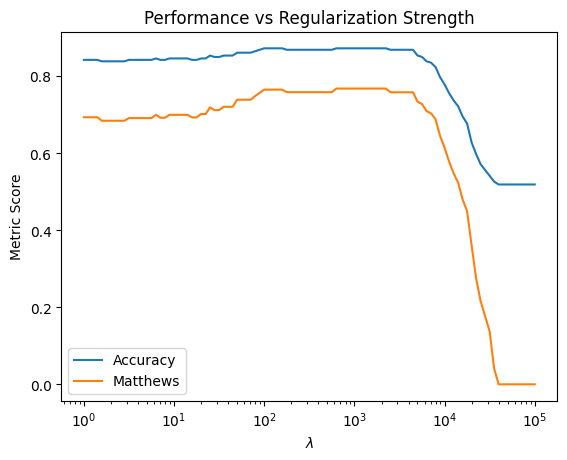

Best Lambda (λ): 100.0000
Best Penalty Parameter (C): 0.0100
Confusion Matrix:
[[0.47761194 0.        ]
 [0.14925373 0.37313433]]
Test Set Accuracy: 85.0746%


In [16]:
y, X = pt.dmatrices("biscoe ~ bill_depth_mm * bill_length_mm * flipper_length_mm * body_mass_g * year * sex + I(bill_depth_mm ** 2) + I(bill_length_mm ** 2)", df2)
y = np.reshape(y, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=608)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lambdas = np.logspace(0, 5, 101)
approx_accuracy = np.zeros_like(lambdas)
approx_matthews = np.zeros_like(lambdas)

for li, l in enumerate(lambdas):
    cv_approx = cross_val_score(
        LogisticRegression(C=1 / l, max_iter=5000),
        X_train_scaled, y_train, cv=5
    )
    cv_matthews = cross_val_score(
        LogisticRegression(C=1 / l, max_iter=5000),
        X_train_scaled, y_train, scoring="matthews_corrcoef", cv=5
    )
    approx_accuracy[li] = np.mean(cv_approx)
    approx_matthews[li] = np.mean(cv_matthews)

plt.plot(lambdas, approx_accuracy, label="Accuracy")
plt.plot(lambdas, approx_matthews, label="Matthews")
plt.xscale("log")
plt.ylabel("Metric Score")
plt.xlabel("$\\lambda$")
plt.legend()
plt.title("Performance vs Regularization Strength")
plt.show()

best_lambda_index = np.argmax(approx_accuracy)
best_lambda = lambdas[best_lambda_index]
best_C = 1 / best_lambda

final_model = LogisticRegression(C=best_C, max_iter=5000).fit(X_train_scaled, y_train)

y_pred = final_model.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test, y_pred, normalize = 'all')
accuracy = accuracy_score(y_test, y_pred)

print(f"Best Lambda (λ): {best_lambda:.4f}")
print(f"Best Penalty Parameter (C): {best_C:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Test Set Accuracy: {accuracy:.4%}")


The confusion matrix is normalized. The diagonal elements (0.4776 and 0.3731) represent the proportions of correctly classified instances for each class.

The off-diagonal elements (0.1493 and 0.0) represent the proportions of misclassified instances.

**Interpretation:**

47.76% of the test samples belong to the first class and are correctly classified.

37.31% of the test samples belong to the second class and are correctly classified.

14.93% of the test samples were misclassified into the wrong class.

**Test Set Accuracy:**

The test set accuracy is 85.07%.

This is a significant improvement over the previous models, indicating that incorporating multiple interaction terms and using the penalized logistic regression model with optimal regularization has enhanced the model's predictive ability.

**Final Interpretation:**

The penalized logistic regression model with interaction terms and optimized regularization (based on λ=100) achieves a test set accuracy of 85.07%.

This performance suggests that the model generalizes well to the test data.

The confusion matrix indicates good classification ability, with a relatively low proportion of misclassified samples.

The chosen regularization strength strikes a balance between underfitting and overfitting, leading to improved accuracy.








# (Using Random Forest)

In [23]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state = 608, bootstrap=True)

rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred, normalize = 'all')

print("Confusion Matrix:")
print(rf_conf_matrix)
print("Accuracy for Random Forest:",rf_accuracy)

Confusion Matrix:
[[0.46268657 0.01492537]
 [0.13432836 0.3880597 ]]
Accuracy for Random Forest: 0.8507462686567164


**Key Hyperparameters in RandomForestClassifier
n_estimators:**

Determines the number of trees in the forest. More trees generally improve robustness but increase training and prediction time.

**Common values:** 10–500 (depending on data size and computational resources).

**max_depth:**

Limits the maximum depth of each decision tree.

Prevents overfitting on small datasets by controlling the tree's growth.

Higher values allow more splits, capturing more details in the data (but can overfit).
